In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import igviz as ig
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


# import src.preprocess as pre
# import src.visualize as vis
# pio.renderers.default = "png"

from src import models, training
from torch_geometric.nn import GAE
import torch
import os

/nethome/mbafna6/miniconda3/envs/CeSpGRN/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
raw_data_path = "./data/seqFISH/"
data_name="seqfish"

# raw_data_path = "./data/MERFISH/"
# data_name="merfish"

# raw_data_path = "./data/scmultisim_final/"
# data_name = "scmultisim_final"


# studyname="spatialedges_withsplit0.1_withgenefeats_withpenalty_120epochs"

studyname="withsplit0.1_withgenefeats_withpenalty_120epochs"

# studyname="withsplit0.1_withgenefeats_120epochs"

preprocess_output_path = f"./out/{data_name}/1_preprocessing_output/"
training_output_path = f"./out/{data_name}/2_training_output/"
evaluation_output_path = f"./out/{data_name}/3_evaluation_output/"

In [3]:


celllevel_data, genelevel_data = training.create_pyg_data(preprocess_output_path, split=None)
data = (celllevel_data, genelevel_data)

data

(Data(x=[1597, 125], edge_index=[2, 7985], y=[1597, 1597]),
 Data(x=[71865, 64], edge_index=[2, 1819947], y=[3233925]))

In [4]:


# delete_data = data[1]

# fp = 0.1
# fn = 0.2

# old_edge_indices = delete_data.edge_index


# def perturb_edges(num_vertices, old_edge_indices, fp, fn):
#     new_edge_indices = None
    
#     if fn != 0:
#         num_keep_edges = int((1-fn) * old_edge_indices.shape[1]) # number of edges to keep after deleting (using false negative rate)
#         keep_edges_indices = np.random.choice(np.array(range(old_edge_indices.shape[1])), size = num_keep_edges, replace=False)
#         new_edge_indices = old_edge_indices[:, keep_edges_indices]
        
#     if fp != 0:
#         num_add_edges = int((fp) * old_edge_indices.shape[1])
        
#         add_edges = torch.from_numpy(np.random.randint(0,high=num_vertices, size=(2,num_add_edges)))
        
#         # add_edges = torch.zeros(size=(2,num_add_edges))

#         # for i in range(num_add_edges):
#         #     sample_edge = torch.from_numpy(np.random.choice(range(old_edge_indices.shape[1]), size = 2, replace=False))
#         #     add_edges[:,i] = sample_edge

#         if new_edge_indices is None:
#             new_edge_indices = torch.cat([old_edge_indices,add_edges],dim=1)
#         else:
#             new_edge_indices = torch.cat([new_edge_indices,add_edges],dim=1)
            
#     return new_edge_indices


# perturb_edges(data[1].x.size()[0],old_edge_indices, fp, fn)


# # len(keep_edges)
# # delete_data

In [5]:
def build_clarifyGAE_pytorch(data, hyperparams = None):
    num_cells, num_cellfeatures = data[0].x.shape[0], data[0].x.shape[1]
    num_genes, num_genefeatures = data[1].x.shape[0], data[1].x.shape[1]
    hidden_dim = hyperparams["concat_hidden_dim"] // 2
    num_genespercell = hyperparams["num_genespercell"]

    cellEncoder = models.GraphEncoder(num_cellfeatures, hidden_dim)
    geneEncoder = models.SubgraphEncoder(num_features=num_genefeatures, hidden_dim=hidden_dim, num_vertices = num_cells, num_subvertices = num_genespercell)
    
    multiviewEncoder = models.MultiviewEncoder(SubgraphEncoder = geneEncoder, GraphEncoder = cellEncoder)
    gae = GAE(multiviewEncoder)

    return gae


hyperparameters = {
    "num_genespercell": 45,
    "concat_hidden_dim": 64,
    "optimizer" : "adam",
    "criterion" : torch.nn.BCELoss(),
    "num_epochs": 400
}

trained_gae = build_clarifyGAE_pytorch(data, hyperparameters)
trained_gae.load_state_dict(torch.load(os.path.join(training_output_path,f'{studyname}_trained_gae_model.pth')))
trained_gae.eval()

GAE(
  (encoder): MultiviewEncoder(
    (encoder_g): SubgraphEncoder(
      (conv1): GCNConv(64, 32)
      (conv2): GCNConv(32, 32)
      (linear): Linear(in_features=1440, out_features=32, bias=True)
    )
    (encoder_c): GraphEncoder(
      (conv1): GCNConv(120, 32)
      (conv2): GCNConv(32, 32)
    )
  )
  (decoder): InnerProductDecoder()
)

In [6]:
data[0].edge_index

tensor([[   0,    0,    0,  ..., 1165, 1137, 1159],
        [   6,   11,   46,  ..., 1196, 1198, 1191]])

In [6]:
cell_level_encoder = trained_gae.encoder.encoder_c
gene_level_encoder = trained_gae.encoder.encoder_g
z, z_c, z_g, gene_embeddings = trained_gae.encode(data[0].x,data[1].x, data[0].edge_index, data[1].edge_index)
z.shape, z_c.shape, z_g.shape, gene_embeddings.shape

(torch.Size([1200, 64]),
 torch.Size([1200, 32]),
 torch.Size([1200, 32]),
 torch.Size([54000, 32]))

In [17]:
expanded_z_c = torch.repeat_interleave(z_c, 45, dim=0)
combined_gene_embeddings = torch.cat([expanded_z_c,gene_embeddings],dim=1)
combined_gene_embeddings.shape

torch.Size([90000, 64])

## Evaluate CCI Inference

In [5]:
baseline_name="DeepLinc"
split=0.3

clarify_metrics_seqfish_df = pd.read_csv(os.path.join(evaluation_output_path, f"metrics_{split}_old.csv"))[["Epoch", "CLARIFY Test AP", "CLARIFY Test ROC"]]
clarify_metrics_seqfish_df[f"{baseline_name} Test AP"] = np.load(f"./benchmark/deeplinc/{data_name}/test_ap_scores_{split}.npy")
clarify_metrics_seqfish_df[f"{baseline_name} Test ROC"] = np.load(f"./benchmark/deeplinc/{data_name}/test_roc_scores_{split}.npy")
clarify_metrics_seqfish_df[f"{baseline_name} Test Accuracy"] = np.load(f"./benchmark/deeplinc/{data_name}/test_acc_scores_{split}.npy")
# clarify_metrics_seqfish_df[f"{baseline_name} Test AUPRC"] = np.load(f"./benchmark/deeplinc/{data_name}/test_auprc_scores_{split}.npy")

from plotly.subplots import make_subplots

def visualize_metrics(df, baseline_name, metric_list=["AP","ROC"]):
    figs = []
    for i,metric in enumerate(metric_list):
        fig = go.Figure()
        xaxistitle = "Epoch"
        yaxistitle = f"{metric}"
        fig.add_trace(
            go.Scatter(x=df[xaxistitle],y=df[f"CLARIFY Test {metric}"], line=dict(color="#d14078"),
                       name="Clarify"),
        )
        fig.add_trace(
            go.Scatter(x=df[xaxistitle],y=df[f"{baseline_name} Test {metric}"], line=dict(color="#345c72"),
                       name=baseline_name),
            
        )
        fig.update_yaxes(rangemode="tozero")
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black',tickfont=dict( size=17, color='black'))
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black',tickfont=dict( size=17, color='black'))
        fig.update_layout(
            title=f"({data_name.upper()}) {yaxistitle} over {xaxistitle}s on {split} testing edges",
            xaxis_title=xaxistitle,
            yaxis_title=yaxistitle,
            legend_title="Model",
            width=800,
            height=600,
            plot_bgcolor="white",
            xaxis=dict( mirror=True,
            ticks='outside',
            showline=True,title=xaxistitle),
            yaxis=dict( mirror=True,
            ticks='outside',
            showline=True,title=yaxistitle)
        )
        figs.append(fig)
    return figs


figs = visualize_metrics(clarify_metrics_seqfish_df, baseline_name="DeepLinc")

for fig in figs:
    fig.show()

In [28]:
from plotly.subplots import make_subplots

clarify_edgemask_df = pd.DataFrame({})

edgemask_figs = []

# metrics = ["AP", "ROC", "AUPRC"]
metrics = ["AP", "ROC"]

for i,metric in enumerate(metrics):
    edge_mask_fig = go.Figure()
    baseline_medians= [0,0,0,0,0]
    clarify_medians = [0,0,0,0,0]
    for i, split in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
        if os.path.exists(f"./benchmark/deeplinc/{data_name}/test_{metric.lower()}_scores_{split}.npy"):
            clarify_edgemask_df[f"{baseline_name} {metric} {split}"] = np.load(f"./benchmark/deeplinc/{data_name}/test_{metric.lower()}_scores_{split}.npy")
            baseline_medians[i]=(np.median(clarify_edgemask_df[f"{baseline_name} {metric} {split}"] ))
            # edge_mask_fig.add_trace(
            #     go.Bar(name=split, y=clarify_edgemask_df[f"{baseline_name} {metric} {split}"], fillcolor="#345c72",  opacity=0.5, line=dict(color='black'), showlegend=False, marker=dict(opacity= 0), offsetgroup=1, width=0)
            # )
        
        if os.path.exists(os.path.join(evaluation_output_path, f"metrics_{split}_old.csv")):
            clarify_df = pd.read_csv(os.path.join(evaluation_output_path, f"metrics_{split}_old.csv"))
            if f"CLARIFY Test {metric}" not in clarify_df.columns:
                break
            metricvals = clarify_df[f"CLARIFY Test {metric}"]
            clarify_medians[i] = np.median(metricvals)
            # edge_mask_fig.add_trace(
            #     go.Box(name=split, y=metricvals, color="#d14078",  opacity=0.5, showlegend=False, marker=dict(opacity= 0), offsetgroup=2, width=0)
            # )


    edge_mask_fig.add_trace(
        go.Bar(x=[0.1, 0.3, 0.5, 0.7, 0.9],y=clarify_medians, marker=dict(color = "#d14078",line=dict(width=2,color='black')),
                    name="Clarify",opacity=0.7),
    ) 
    edge_mask_fig.add_trace(
        go.Bar(x=[0.1, 0.3, 0.5, 0.7, 0.9],y=baseline_medians, marker=dict(color = "#345c72", line=dict(width=2,color='black')),
                    name=baseline_name,opacity=0.7)
    ) 
    
    xaxistitle = "% Test Edges"
    yaxistitle = f"{metric}"
    edge_mask_fig.update_yaxes(rangemode="tozero")
    edge_mask_fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, ticks='outside',tickfont=dict( size=17, color='black'))
    edge_mask_fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,ticks='outside',tickfont=dict( size=17, color='black'))
    edge_mask_fig.update_layout(
        title=f"({data_name.upper()}) {yaxistitle} vs. {xaxistitle}",
        xaxis_title=xaxistitle,
        yaxis_title=yaxistitle,
        legend_title="Model",
        width=800,
        height=600,
        boxmode='group',
        plot_bgcolor='white'
    )
    edgemask_figs.append(edge_mask_fig)
        
# clarify_edgemask_df

for i,fig in enumerate(edgemask_figs):
    fig.show()


In [112]:

# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=spatial_domain_predictions,  labels={'color': 'Spatial Domain'}
# )

# fig_2d.show()

## Visualize Reconstructed CCI Graph

<AxesSubplot: >

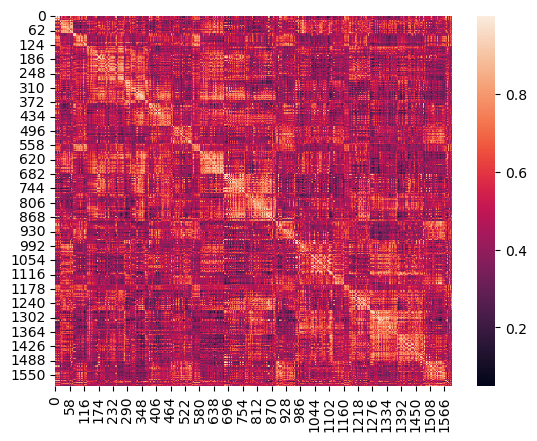

In [24]:
recon_Ac = trained_gae.decoder.forward_all(z).detach().numpy()
sns.heatmap(recon_Ac)

In [76]:
# thresholded_Ac = recon_Ac > 0.95
from scipy.linalg import block_diag

one_block = np.ones(shape=(80,80))
block_list = [one_block for _ in range(19)]
block_list.append(np.ones(shape=(77,77)))
mask = block_diag(*block_list).astype(bool)

thresholded_Ac = (recon_Ac * mask ) > 0.9

thresholded_Ac.sum(), thresholded_Ac.shape

(5886, (1597, 1597))

In [77]:
import networkx as nx
G = nx.from_numpy_array(thresholded_Ac)

node_positions = pd.read_csv(os.path.join(raw_data_path,f"{data_name}_dataframe.csv"))[["X","Y"]]

for i, rowloc in node_positions.iterrows():
    G.nodes[i]['pos'] = (rowloc["X"],rowloc["Y"])

len(G.edges)

3381

In [78]:
len(G.edges()), len(edges[0])

(3381, 23955)

In [79]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)




In [87]:
from src.visualize import visualize_celllevel_graph
import sys
sys.path.append('./src/')
sys.path.append('./src/submodules/CeSpGRN/src/')
from src.preprocessing import construct_celllevel_graph



starting_df = pd.read_csv(os.path.join(raw_data_path,f"{data_name}_dataframe.csv"))

celllevel_adj, edges = construct_celllevel_graph(starting_df, 5, get_edges=True)

sim_fig = visualize_celllevel_graph(starting_df, gene="X",title="", edge_trace=edges, publication=True)
sim_fig.update_layout(
    plot_bgcolor="white"
)
sim_fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=False, ticks='outside')
sim_fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=False,ticks='outside')
sim_fig.update_coloraxes(showscale=False)
sim_fig.update_traces(marker=dict(color='gray'))
# sim_fig.add_trace(
#     go.Scatter(
#     x=edge_x, y=edge_y,
#     line=dict(width=0.5, color='red'),
#     hoverinfo='none',
#     mode='lines')
# )
sim_fig.show()

### Relevant Spatial Domains found from Embeddings?

In [119]:
from umap import UMAP
from sklearn.cluster import KMeans

spatial_domain_predictions = KMeans(n_clusters=6, random_state=0).fit_predict(z_c.detach().numpy())

spatial_domain_predictions.shape

(1597,)

In [120]:
from src.visualize import visualize_celllevel_graph

full_cell_df = pd.read_csv(os.path.join(raw_data_path,f"{data_name}_dataframe.csv"))
full_cell_df["domain"] = spatial_domain_predictions.astype(int).astype(str)

np.unique(full_cell_df["domain"] )


cells_fig = visualize_celllevel_graph(full_cell_df, gene="domain", title="Spatial Domain Visualization", publication=True)
cells_fig.update_layout(coloraxis_colorbar_x=1)

cells_fig.show()



# cells_fig.write_image("./out/seqfish/3_evaluation_output/celllevel_spatial_domains.png")


SpearmanrResult(correlation=0.6956708789651185, pvalue=0.0)
SpearmanrResult(correlation=0.2521997620030433, pvalue=0.0)


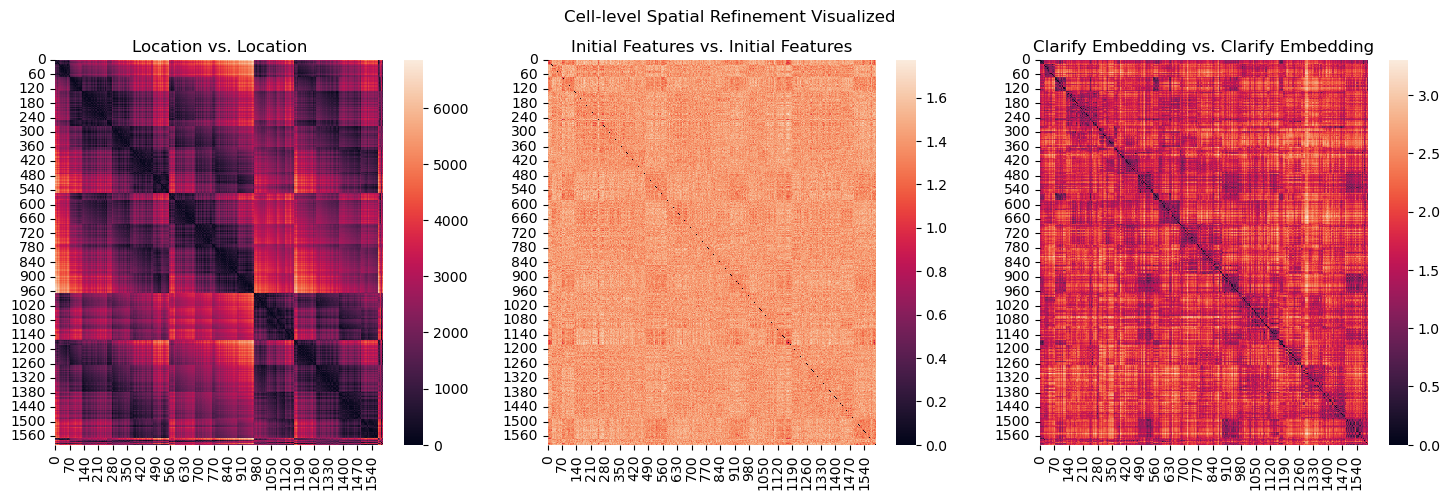

In [83]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr, wilcoxon
from scipy.linalg import block_diag


def visualize_spatial_refinement_heatmaps(initial_features, raw_embeddings, coordinates, type="Cell"):
    
    location_heatmap = euclidean_distances(coordinates,coordinates)
    embedding_heatmap = euclidean_distances(raw_embeddings,raw_embeddings)
    initial_heatmap = euclidean_distances(initial_features,initial_features)

    mask = np.triu_indices(initial_heatmap.shape[0], k=1)

    one_block = np.ones(shape=(60,60))
    block_list = [one_block for _ in range(26)]
    block_list.append(np.ones(shape=(37,37)))
    mask = block_diag(*block_list).astype(bool)
    

    
    # one_block = np.ones(shape=(75,75))
    # block_list = [one_block for _ in range(26)]
    # block_list.append(np.ones(shape=(50,50)))
    # mask = block_diag(*block_list).astype(bool)
    
    # one_block = np.ones(shape=(60,60))
    # block_list = [one_block for _ in range(20)]
    # mask = block_diag(*block_list).astype(bool)
    
    
    # print(mask.shape)

    print(spearmanr(location_heatmap[mask], embedding_heatmap[mask]))
    print(spearmanr(location_heatmap[mask], initial_heatmap[mask]))

    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18,5))
    fig.suptitle(f'{type}-level Spatial Refinement Visualized')
    axes[0].set_title(f'Location vs. Location')
    axes[1].set_title(f'Initial Features vs. Initial Features')
    axes[2].set_title(f'Clarify Embedding vs. Clarify Embedding')
    axes[0].set_yticks((0, len(initial_heatmap)), minor=False)
    
    sns.heatmap(location_heatmap, ax = axes[0])
    sns.heatmap(initial_heatmap, ax = axes[1])
    sns.heatmap(embedding_heatmap, ax = axes[2])
    
    
    return fig


locations= pd.read_csv("./data/seqFISH/coord.csv").values

# locations= pd.read_csv("./data/MERFISH/merfish_dataframe.csv")[["X","Y"]].values

cell_spatial_refinement = visualize_spatial_refinement_heatmaps(data[0].x, z_c.detach().numpy(), locations)


# cell_spatial_refinement = visualize_spatial_refinement_heatmaps(data[0].x, gene_embeddings.detach().numpy(), locations)

    



### Evaluate SpaOTsc

In [13]:
spaotsc_res = pd.read_csv(f"./data/scMultiSim_final/simulated/spaot_results.csv")
scmultisim_gt = pd.read_csv(f"./data/scMultiSim_final/simulated/cci_gt.csv")
scmultisim_df = pd.read_csv(f"./data/scMultiSim_final/scmultisim_dataframe.csv")
# spaotsc_set = set()

# for i,row in spaotsc_res.iterrows():
#     genepair = row["Unnamed: 0"]
    
#     combination_list = genepair+"-"+spaotsc_res.columns[1:]
    
#     for combo in combination_list:
#         spaotsc_set.add(combo)  
        
# gt_set = set() 

# for i,row in scmultisim_gt.iterrows():
#     cci = f"{row['ligand']}-{row['receptor']}-CT{row['ct1']}-CT{row['ct2']}"
#     gt_set.add(cci)
    

In [181]:
# tp = len(gt_set.intersection(spaotsc_set))
# fp = len(spaotsc_set - gt_set)
# fn = len(gt_set-spaotsc_set)

# precision = tp/(tp+fp)
# recall = tp/(tp+fn)
# f1 = 2*precision*recall / (precision+recall)
# jaccard = len(gt_set.intersection(spaotsc_set)) / len(gt_set.union(spaotsc_set))

# precision, recall, f1, jaccard

'2_1_5'

In [14]:
spaotsc_Ac_types = set(spaotsc_res.columns[1:])
spaotsc_Ac = np.zeros((1200,1200))

for i in range(1200):
    cell1type = scmultisim_df["Cell_Type"][i].split("_")[-1]
    for j in range(1200):
        cell2type = scmultisim_df["Cell_Type"][j].split("_")[-1]
        spaotsc_cci = f"CT{cell1type}-CT{cell2type}"
        if spaotsc_cci in spaotsc_Ac_types:
            spaotsc_Ac[i][j] = 1
        

In [11]:
recon_Ac = trained_gae.decoder.forward_all(z).detach().numpy()
gt_Ac = np.load("./out/scmultisim_final/1_preprocessing_output/celllevel_adjacencymatrix.npy")



preprocess_output_path = f"./out/{data_name}/1_preprocessing_output/"
training_output_path = f"./out/{data_name}/2_training_output/"
# evaluation_output_path = f"./out/{data_name}/3_evaluation_output/"
(cell_train_data, cell_test_data), genelevel_data = training.create_pyg_data(preprocess_output_path, split=0.99)
data = (cell_train_data, genelevel_data)

from sklearn.metrics import f1_score, roc_auc_score, jaccard_score, accuracy_score, average_precision_score, auc, precision_recall_curve

# roc_auc_score(gt_Ac.flatten(),recon_Ac.flatten()), average_precision_score(gt_Ac.flatten(),recon_Ac.flatten())

def metrics(model, z, pos_edge_index, neg_edge_index):

    torch.manual_seed(0)

    pos_y = z.new_ones(pos_edge_index.size(1))
    neg_y = z.new_zeros(neg_edge_index.size(1))
    y = torch.cat([pos_y, neg_y], dim=0)

    pos_pred = model.decode(z, pos_edge_index, sigmoid=True)
    neg_pred = model.decode(z, neg_edge_index, sigmoid=True)
    pred = torch.cat([pos_pred, neg_pred], dim=0)
    

    y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()
    
    
    precision, recall, _ = precision_recall_curve(y, pred)
    auprc = auc(recall, precision)
    auroc = roc_auc_score(y, pred)
    ap = average_precision_score(y,pred)

    return auprc,ap, auroc

def evaluate_model(studyname, data_name):

    hyperparameters = {
        "num_genespercell": 45,
        "concat_hidden_dim": 64,
        "optimizer" : "adam",
        "criterion" : torch.nn.BCELoss(),
        "num_epochs": 400
    }

    trained_gae = build_clarifyGAE_pytorch(data, hyperparameters)
    trained_gae.load_state_dict(torch.load(os.path.join(training_output_path,f'{studyname}_trained_gae_model.pth')))
    trained_gae.eval()
    
    # cell_level_encoder = trained_gae.encoder.encoder_c
    # gene_level_encoder = trained_gae.encoder.encoder_g
    z, z_c, z_g, gene_embeddings = trained_gae.encode(cell_test_data.x,data[1].x, cell_test_data.edge_index, data[1].edge_index)
    print(cell_train_data, cell_test_data)

    posmask = cell_test_data.edge_label == 1
    negmask = ~posmask

    
    return metrics(trained_gae, z, cell_test_data.edge_label_index[:, posmask], cell_test_data.edge_label_index[:,negmask])


evaluate_model(studyname, data_name)

# roc_auc_score(gt_Ac.flatten(),recon_Ac.flatten())



0.010000000000000009 training edges | 0.99 testing edges
Data(x=[1200, 120], edge_index=[2, 36], y=[1200, 1200], edge_label=[36], edge_label_index=[2, 36]) Data(x=[1200, 120], edge_index=[2, 36], y=[1200, 1200], edge_label=[3374], edge_label_index=[2, 3374])


(0.6864662846785508, 0.6866649185109139, 0.7233343019548)

In [17]:
p,r,_ = precision_recall_curve(gt_Ac.flatten(),spaotsc_Ac.flatten())
roc_auc_score(gt_Ac.flatten(),spaotsc_Ac.flatten()), auc(r,p)

(0.5, 0.5015131944444444)

In [38]:
permuted_gt_ac = np.random.permutation(gt_Ac.flatten())
p,r,_ = precision_recall_curve(gt_Ac.flatten(),permuted_gt_ac)
roc_auc_score(gt_Ac.flatten(),permuted_gt_ac), average_precision_score(gt_Ac.flatten(),permuted_gt_ac), auc(r,p)


(0.4998631697928243, 0.0030256376299310716, 0.00426258445515272)

In [35]:
sum(permuted_gt_ac == 1)/ permuted_gt_ac.shape[0]

0.003026388888888889

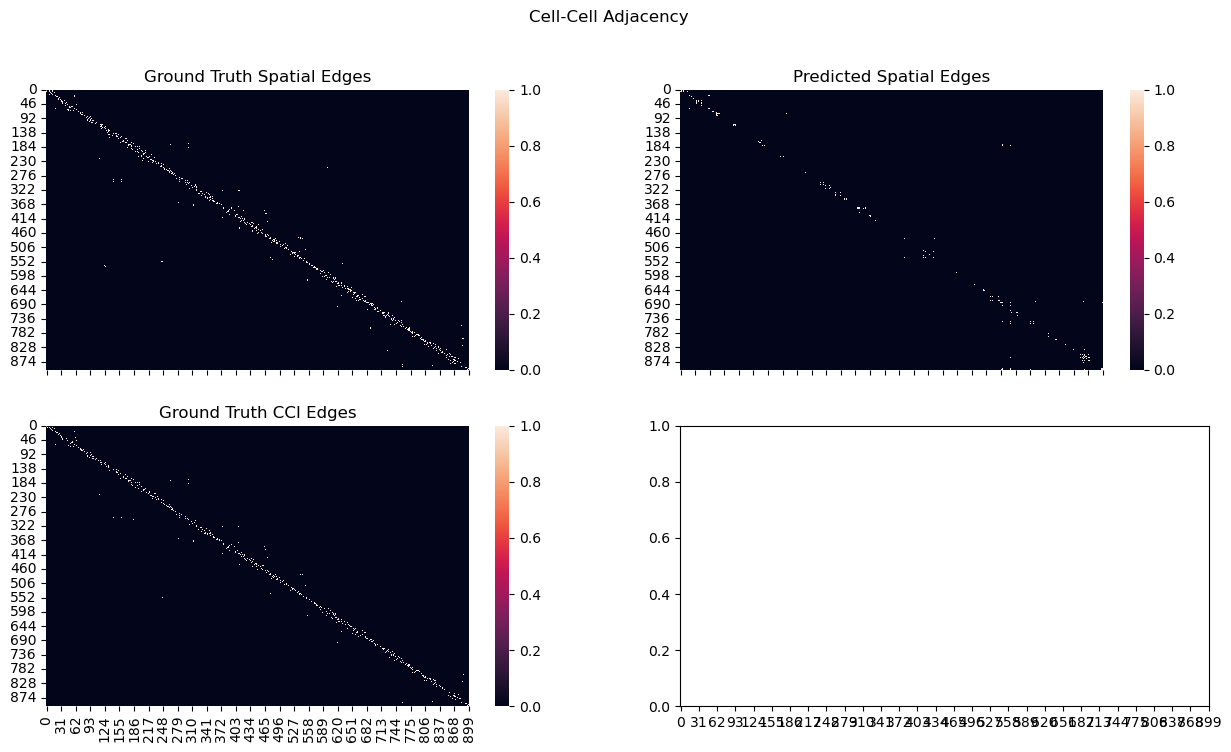

In [46]:
def visualize_cell_adjacency(cell_gt_adjacency, cell_embeddings, cci_adjacency, num_cells=900):
    
    pred_cell_heatmap = torch.sigmoid(torch.matmul(cell_embeddings, cell_embeddings.t())).detach().numpy()
    
    pred_cell_heatmap = pred_cell_heatmap > 0.95
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,8))
    fig.suptitle('Cell-Cell Adjacency')
    axes[0,0].set_title('Ground Truth Spatial Edges')
    axes[0,1].set_title('Predicted Spatial Edges')
    axes[1,0].set_title('Ground Truth CCI Edges')

    sns.heatmap(cell_gt_adjacency[:num_cells,:num_cells], ax = axes[0,0])
    sns.heatmap(pred_cell_heatmap[:num_cells,:num_cells], ax = axes[0,1])
    sns.heatmap(cci_adjacency[:num_cells,:num_cells], ax = axes[1,0])
    # return fig

cell_gt_adjacency = np.load(os.path.join(preprocess_output_path, "celllevel_adjacencymatrix.npy"))
cci_adjacency = pd.read_csv(os.path.join(raw_data_path, "adj.csv")).to_numpy()

visualize_cell_adjacency(cell_gt_adjacency, z, cci_adjacency)


## Evaluate GRN Refinement

In [96]:
from numpy.lib.stride_tricks import sliding_window_view
from scipy.linalg import block_diag

num_genespercell = 45
# num_cells = 2000
# num_cells = 1597
num_cells = 1200

# initial_gene_features = data[1].x.detach().numpy()
# pooled_gene_initial_features = np.zeros(shape=(initial_gene_features.shape[0] // num_genespercell, initial_gene_features.shape[1] ))

# for i in range(pooled_gene_initial_features.shape[0]):
#     start = i * num_genespercell
#     end = start + num_genespercell
#     pooled  = np.mean(initial_gene_features[start:end, :], axis=0)
#     pooled_gene_initial_features[i:i+1, :] = pooled

# initial_gene_features = pooled_gene_initial_features

# initial_gene_features = np.reshape(initial_gene_features, newshape=(initial_gene_features.shape[0]//num_genespercell, initial_gene_features.shape[1]*num_genespercell))

def create_intracellular_gene_mask(num_cells, num_genespercell):
  one_block = np.ones(shape=(num_genespercell,num_genespercell))
  block_list = [one_block for _ in range(num_cells)]
  return block_diag(*block_list)

intracellular_gene_mask = create_intracellular_gene_mask(num_cells, num_genespercell)

# recon_Ag_flat = trained_gae.decoder.forward_all(torch.from_numpy(weighted_combined_gene_embeddings))[intracellular_gene_mask.astype(bool)].detach().numpy()
recon_Ag_flat = trained_gae.decoder.forward_all(gene_embeddings)[intracellular_gene_mask.astype(bool)].detach().numpy()


# genelevel_spatial_refinement = visualize_spatial_refinement_heatmaps(initial_gene_features, z_g.detach().numpy(), locations, type="Gene")


In [99]:


recon_Ag = np.reshape(recon_Ag_flat, (num_cells, num_genespercell,num_genespercell))

og_ge = data[1].y.detach().numpy()
original_Ag = np.reshape(og_ge,  (num_cells, num_genespercell,num_genespercell))
# original_Ag
np.save("./benchmark/genie3/clarify_grns.npy", recon_Ag)


In [15]:
len(og_ge[og_ge>0.1]), len(recon_Ag_flat[recon_Ag_flat > 0.5])

(84493, 3186547)

In [10]:
thresholded_og_Ag = (original_Ag >  0.96).astype(int)
thresholded_recon_Ag = (recon_Ag > 0.1).astype(int)


In [85]:
from scipy.spatial.distance import jaccard
from sklearn.metrics import f1_score


def matrix_distance(a, b):
    return np.abs(np.linalg.norm(a,'fro')-np.linalg.norm(b,'fro'))



def gene_level_heatmap(grns):
    num_cells = grns.shape[0]
    print(num_cells)
    genelevel_heatmap = np.zeros(shape=(num_cells,num_cells))

    for i in range(num_cells):
        for j in range(num_cells):
            # genelevel_heatmap[i][j] = matrix_distance(grns[i,:,:],grns[j,:,:])
            # genelevel_heatmap[i][j] = jaccard(grns[i,:,:].flatten(),grns[j,:,:].flatten())
            genelevel_heatmap[i][j] = np.linalg.norm(grns[i,:,:].flatten() - grns[j,:,:].flatten())

    return genelevel_heatmap

genelevel_heatmap_recon = gene_level_heatmap(recon_Ag)
genelevel_heatmap_og = gene_level_heatmap(original_Ag)

1597
1597


In [86]:


location_heatmap = euclidean_distances(locations,locations)

one_block = np.ones(shape=(60,60))
block_list = [one_block for _ in range(26)]
block_list.append(np.ones(shape=(37,37)))
mask = block_diag(*block_list).astype(bool)

 
print(mask.shape)


spearmanr(location_heatmap[mask], genelevel_heatmap_recon[mask]),spearmanr(location_heatmap[mask], genelevel_heatmap_og[mask])

(1597, 1597)


(SpearmanrResult(correlation=0.2523120547050074, pvalue=0.0),
 SpearmanrResult(correlation=0.10148941998115542, pvalue=7.905679089701677e-216))

In [87]:
mask = np.triu_indices(num_cells, k=1)

spearmanr(location_heatmap[mask], genelevel_heatmap_recon[mask]),spearmanr(location_heatmap[mask], genelevel_heatmap_og[mask])

(SpearmanrResult(correlation=0.10727841233984382, pvalue=0.0),
 SpearmanrResult(correlation=-0.00023399421759909029, pvalue=0.7916605907200445))

<AxesSubplot: >

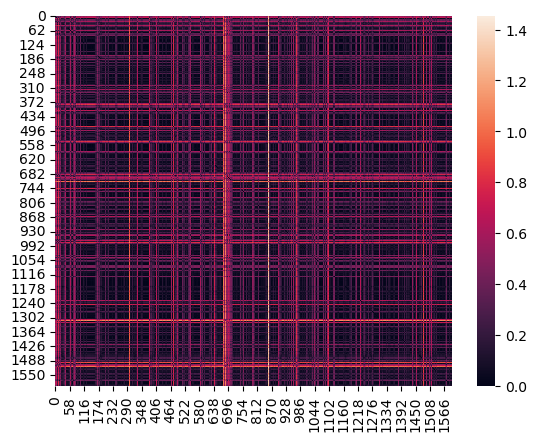

In [45]:
sns.heatmap(genelevel_heatmap_recon)

<AxesSubplot: >

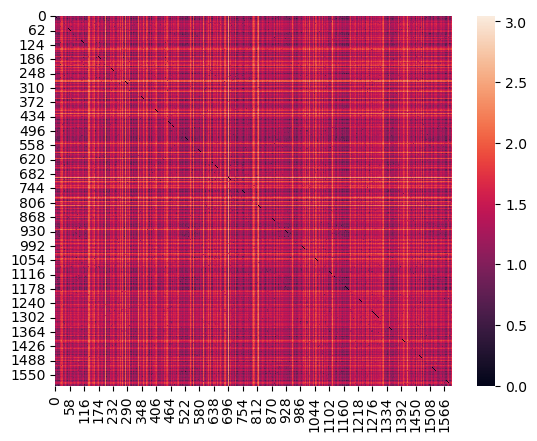

In [46]:
sns.heatmap(genelevel_heatmap_og)

In [10]:
# import umap

# numsubgraphs = 20
# genespercell = 45

# cellnumbers = []

# gae_gene_embeddings = z_g[:genespercell*numsubgraphs, :].detach().numpy()
# print(f"Selected {gae_gene_embeddings.shape[0]} out of {z_g.shape[0]} genes")

# for i in range(numsubgraphs):
#     val = f'Cell{i}'
#     for j in range(genespercell):
#         cellnumbers.append(val)

# umap_manifold = umap.UMAP(n_neighbors=20, random_state=42).fit(gae_gene_embeddings)

# df = pd.DataFrame({"UMAP1":umap_manifold.embedding_[:, 0], "UMAP2":umap_manifold.embedding_[:, 1], "Cell #":cellnumbers})
# df


In [19]:
graphsaint_gene_embeddings = torch.load(os.path.join(preprocess_output_path, "graphsaint_gcn_embeddings.pth")).detach().numpy()
np.save(os.path.join(preprocess_output_path, "genelevel_features"), graphsaint_gene_embeddings)

In [143]:
import umap

def project_genes(embeddings, num_cells, num_genespercell, type):
    cellnumbers = []
    gae_gene_embeddings = None

    if type == "None":
        for i in range(num_cells):
            val = f'Cell{i}'
            for j in range(num_genespercell):
                cellnumbers.append(val)

        gae_gene_embeddings = embeddings[:num_genespercell*num_cells]
        print(f"Selected {gae_gene_embeddings.shape[0]} out of {embeddings.shape[0]} genes")

        
    elif type == "pool":
        for i in range(num_cells):
            val = f'Cell{i}'
            cellnumbers.append(val)
            
        gae_gene_embeddings = embeddings[:num_cells, :]
    #    print(f"Selected {gae_gene_embeddings.shape[0]} out of {embeddings.shape[0]} cells")
    elif type == "concat":
        for i in range(num_cells):
            val = f'Cell{i}'
            cellnumbers.append(val)
            
        gae_gene_embeddings = embeddings[:num_genespercell*num_cells, :]
        print(gae_gene_embeddings.shape)
        gae_gene_embeddings = np.reshape(gae_gene_embeddings, (gae_gene_embeddings.shape[0]//num_genespercell, gae_gene_embeddings.shape[1] * num_genespercell))
        

    assert gae_gene_embeddings is not None

    umap_manifold = umap.UMAP(n_neighbors=num_cells, random_state=42).fit(gae_gene_embeddings)

    df = pd.DataFrame({"UMAP1":umap_manifold.embedding_[:, 0], "UMAP2":umap_manifold.embedding_[:, 1], "Cell #":cellnumbers})

    return df
  
num_cells = 10
num_genespercell = 45


# pred_grnumap_df= project_genes(gene_embeddings.detach().numpy(), num_cells=num_cells, num_genespercell=num_genespercell, type="None")
pred_grnumap_df= project_genes(weighted_combined_gene_embeddings, num_cells=num_cells, num_genespercell=num_genespercell, type="None")

gt_grnumap_df= project_genes(data[1].x.detach().numpy(), num_cells=num_cells, num_genespercell=num_genespercell, type="concat")
# gt_grnumap_df= project_genes(graphsaint_gene_embeddings ,num_cells=num_cells, num_genespercell=num_genespercell, type="None")

display(gt_grnumap_df)
display(pred_grnumap_df)

Selected 450 out of 90000 genes
(450, 64)


/nethome/mbafna6/.local/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



UMAP1      UMAP2 Cell #
0  13.526805  18.458109  Cell0
1  13.647515  17.019203  Cell1
2  14.408862  16.562368  Cell2
3  14.978940  17.105633  Cell3
4  15.025267  19.145050  Cell4
5  15.427244  18.385485  Cell5
6  14.282206  19.046171  Cell6
7  13.960320  17.771915  Cell7
8  13.018352  17.775476  Cell8
9  14.710404  18.029636  Cell9

UMAP1     UMAP2 Cell #
0    -2.683530 -7.371299  Cell0
1    -1.458859 -4.653614  Cell0
2    -2.570602 -7.529093  Cell0
3    -1.414855 -4.610471  Cell0
4    -2.128976 -6.357825  Cell0
..         ...       ...    ...
445  18.734463 -2.768703  Cell9
446  11.643757 -5.513778  Cell9
447  11.762875 -5.519543  Cell9
448  11.710787 -5.555812  Cell9
449  11.643067 -5.468541  Cell9

[450 rows x 3 columns]

In [144]:
px.scatter(pred_grnumap_df, x="UMAP1",y="UMAP2", color="Cell #",   width=800, height=600, color_discrete_sequence=px.colors.qualitative.Prism)

In [149]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)


components = pd.DataFrame(pca.fit_transform(data[1].x.detach().numpy()))

cellnumbers = []

num_cells = 10

for i in range(1597):
    val = f'Cell{i}'
    for j in range(45):
        cellnumbers.append(val)

components["Cell #"] = cellnumbers

components = components[:45*num_cells]

px.scatter(components, x=0,y=1, color="Cell #",   width=800, height=600, color_discrete_sequence=px.colors.qualitative.Prism)

In [141]:
pca = PCA(n_components=2)

celllevel_weightage = 0.4

weighted_combined_gene_embeddings = np.sum(torch.stack([celllevel_weightage * expanded_z_c, (1-celllevel_weightage) * gene_embeddings],dim=0).detach().numpy(), axis=0)

weighted_combined_gene_embeddings.shape

components = pd.DataFrame(pca.fit_transform(weighted_combined_gene_embeddings))

cellnumbers = []

num_cells = 10
total_cells = 2000

for i in range(total_cells):
    val = f'Cell{i}'
    for j in range(num_genespercell):
        cellnumbers.append(val)

components["Cell #"] = cellnumbers

components = components[:45*num_cells]

px.scatter(components, x=0,y=1, color="Cell #",  width=800, height=600, color_discrete_sequence=px.colors.qualitative.Prism)

In [24]:
genelevel_edges = np.load(os.path.join(preprocess_output_path, "genelevel_edgelist.npy")).T
genelevel_graph = nx.from_edgelist(genelevel_edges)
genelevel_graph

In [13]:
genelevel_adjmatrix = nx.to_numpy_array(genelevel_graph)
genelevel_adjmatrix.shape

(71865, 71865)

In [10]:
from scipy.linalg import block_diag

def create_intracellular_gene_mask(num_cells, num_genespercell):
  one_block = np.ones(shape=(num_genespercell,num_genespercell))
  block_list = [one_block for _ in range(num_cells)]
  return block_diag(*block_list)

intracellular_gene_mask = create_intracellular_gene_mask(1597, 45)
intracellular_gene_mask.shape

(71865, 71865)

In [12]:
genelevel_adjmatrix_masked = genelevel_adjmatrix[intracellular_gene_mask.astype(bool)]
np.save()

(3233925,)

In [14]:
genelevel_adjmatrix[intracellular_gene_mask.astype(bool)]

array([1., 1., 1., ..., 0., 0., 1.])

In [24]:
recon_grns = []
for i in range(z_g.shape[0]):
    z_gi = z_g[i].unsqueeze(1)
    recon_grns.append(z_gi @ z_gi.T)
    # 
torch.stack(recon_grns,dim=0).shape

torch.Size([1597, 32, 32])

In [15]:
np.load(os.path.join(preprocess_output_path, "initial_grns.npy")).flatten().shape

(3233925,)

In [13]:
data[1].y

tensor([ 0.8856, -0.0105, -0.0000,  ..., -0.0000, -0.0000,  0.9034])